<a href="https://colab.research.google.com/github/gbrao018/eva4/blob/master/S6_L1_L2_40_epochs_lambda_0_0003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             100
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 24, 10, 10]           2,160
             ReLU-12           [-1, 24, 10, 10]               0
      BatchNorm2d-13           [-1, 24, 10, 10]              48
          Dropout-14           [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #print('y_pred=',len(y_pred.dataset),'target=',len(target.dataset))
    loss = F.nll_loss(y_pred, target)
    #print('loss=',loss)
    
    #Add L1 regularization
    #loss = F.L1loss(y_pred, target)
    #l1_crit=F.L1loss(reduction='sum')
    l1_l2_reg_loss = 0
    
    for p in model.parameters():
      l1_l2_reg_loss += torch.sum(torch.abs(p.data))+torch.sum(p.data.pow(2))
    #for p in model.parameters():
      #l1_l2_reg_loss += torch.abs(p.data)+p.data.pow(2)
  
    alpha= float(0.0003)
    loss+=alpha*l1_l2_reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Loss=2.4899823665618896 Batch_id=0 Accuracy=10.94:   0%|          | 1/938 [00:00<02:13,  7.04it/s]

EPOCH: 0


Loss=0.34833449125289917 Batch_id=937 Accuracy=91.42: 100%|██████████| 938/938 [01:34<00:00, 11.11it/s]
Loss=0.3270677924156189 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:42,  9.10it/s]


Test set: Average loss: 0.0778, Accuracy: 9775/10000 (97.75%)

EPOCH: 1


Loss=0.37835338711738586 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [01:33<00:00, 10.51it/s]
Loss=0.35707539319992065 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:39,  9.44it/s]


Test set: Average loss: 0.0452, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.41787856817245483 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [01:32<00:00, 10.82it/s]
Loss=0.33722126483917236 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:25, 10.98it/s]


Test set: Average loss: 0.0335, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.3444181978702545 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [01:31<00:00, 10.29it/s]
Loss=0.4178088903427124 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<01:40,  9.31it/s]


Test set: Average loss: 0.0314, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.41126421093940735 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [01:33<00:00, 10.79it/s]
Loss=0.4375935196876526 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:40,  9.32it/s]


Test set: Average loss: 0.0313, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.37897607684135437 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [01:30<00:00, 10.36it/s]
Loss=0.3666402995586395 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.85it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.3710802495479584 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [01:30<00:00, 11.08it/s]
Loss=0.3727879226207733 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:26, 10.77it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.38752076029777527 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:28<00:00, 11.35it/s]
Loss=0.41812005639076233 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:27, 10.64it/s]


Test set: Average loss: 0.0238, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.39654412865638733 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [01:28<00:00, 10.64it/s]
Loss=0.4060951769351959 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:49,  8.53it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.400443434715271 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [01:28<00:00, 11.43it/s]
Loss=0.39975324273109436 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:28, 10.58it/s]


Test set: Average loss: 0.0220, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.6006608605384827 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [01:28<00:00, 10.54it/s]
Loss=0.534020721912384 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:24, 11.04it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.4286098778247833 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [01:31<00:00, 10.61it/s]
Loss=0.4287758767604828 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:26, 10.81it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.4662684202194214 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:30<00:00, 10.37it/s]
Loss=0.41449877619743347 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:29, 10.50it/s]


Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.4197531044483185 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:28<00:00, 11.34it/s]
Loss=0.464069128036499 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:26, 10.84it/s]


Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.4349619448184967 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [01:28<00:00, 11.57it/s]
Loss=0.42791980504989624 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.55it/s]


Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.4336099624633789 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [01:28<00:00, 11.58it/s]
Loss=0.441351056098938 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:24, 11.07it/s]


Test set: Average loss: 0.0215, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.43704450130462646 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [01:27<00:00, 10.73it/s]
Loss=0.45488616824150085 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:27, 10.67it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.47470593452453613 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [01:26<00:00, 11.98it/s]
Loss=0.4792076051235199 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:30, 10.37it/s]


Test set: Average loss: 0.0200, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.44851067662239075 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [01:26<00:00, 10.87it/s]
Loss=0.5508511066436768 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:22, 11.32it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.45170721411705017 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [01:31<00:00, 10.27it/s]
Loss=0.45261064171791077 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.60it/s]


Test set: Average loss: 0.0239, Accuracy: 9919/10000 (99.19%)

EPOCH: 20


Loss=0.47092607617378235 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:27<00:00, 11.39it/s]
Loss=0.5606946349143982 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:23, 11.21it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.49111607670783997 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [01:25<00:00, 10.91it/s]
Loss=0.46284785866737366 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:24, 11.08it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.4646422564983368 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [01:27<00:00, 10.68it/s]
Loss=0.5092296004295349 Batch_id=1 Accuracy=95.31:   0%|          | 2/938 [00:00<01:25, 10.92it/s]


Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 23


Loss=0.7002406120300293 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [01:28<00:00, 10.65it/s]
Loss=0.47386452555656433 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:28, 10.63it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.4806444048881531 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [01:28<00:00, 10.61it/s]
Loss=0.5029376745223999 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:30, 10.37it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.5262850522994995 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:28<00:00, 11.07it/s]
Loss=0.600862979888916 Batch_id=1 Accuracy=96.88:   0%|          | 1/938 [00:00<01:33,  9.98it/s] 


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 26


Loss=0.49967899918556213 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:34<00:00,  9.95it/s]
Loss=0.5235978960990906 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:38,  9.48it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 27


Loss=0.4953550398349762 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:35<00:00,  9.82it/s]
Loss=0.49251505732536316 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:30, 10.29it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 28


Loss=0.5111724138259888 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]
Loss=0.49052539467811584 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:34,  9.89it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 29


Loss=0.5358529090881348 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [01:32<00:00, 10.12it/s]
Loss=0.4972285032272339 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:27, 10.65it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.49881061911582947 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [01:31<00:00, 10.29it/s]
Loss=0.5301048755645752 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:34,  9.88it/s]


Test set: Average loss: 0.0174, Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.570005476474762 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:30<00:00, 10.36it/s]
Loss=0.5024834871292114 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:32, 10.14it/s]


Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.5407771468162537 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [01:31<00:00, 11.32it/s]
Loss=0.5280889272689819 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:33,  9.99it/s] 


Test set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH: 33


Loss=0.5378953814506531 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [01:31<00:00, 10.21it/s]
Loss=0.5192288756370544 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:28, 10.62it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


Loss=0.5699044466018677 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:31<00:00, 10.72it/s]
Loss=0.5386009216308594 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:31, 10.24it/s]


Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)

EPOCH: 35


Loss=0.5240063071250916 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:31<00:00, 11.04it/s]
Loss=0.5153854489326477 Batch_id=1 Accuracy=99.22:   0%|          | 1/938 [00:00<01:36,  9.72it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Loss=0.518783450126648 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:31<00:00, 10.29it/s]
Loss=0.5200249552726746 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:35,  9.86it/s]


Test set: Average loss: 0.0175, Accuracy: 9939/10000 (99.39%)

EPOCH: 37


Loss=0.5226172804832458 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:33<00:00, 10.48it/s]
Loss=0.5270687937736511 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:40,  9.35it/s]


Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 38


Loss=0.6224321722984314 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:33<00:00,  9.99it/s]
Loss=0.5279718041419983 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:29, 10.45it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 39


Loss=0.579804539680481 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:33<00:00, 10.01it/s]



Test set: Average loss: 0.0187, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

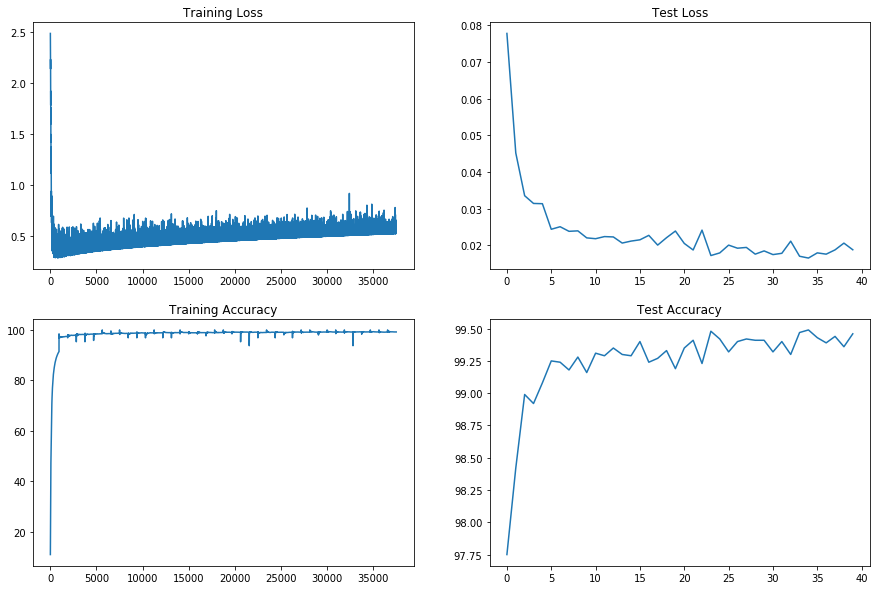

In [11]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(2,2,figsize=(15,10))
#print('train_losses=',len(train_losses))
#print('test_losses=',len(test_losses))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")